In [1]:
%pip install tensorflow==2.9.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 35.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: tensorflow-estimator
 

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [3]:
print(os.listdir('../input/data/'))

['test', 'train']


# Read in the Data

In [4]:
folder_benign_train = '../input/data/train/benign'
folder_malignant_train = '../input/data/train/malignant'

folder_benign_test = '../input/data/test/benign'
folder_malignant_test = '../input/data/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

# Display Data

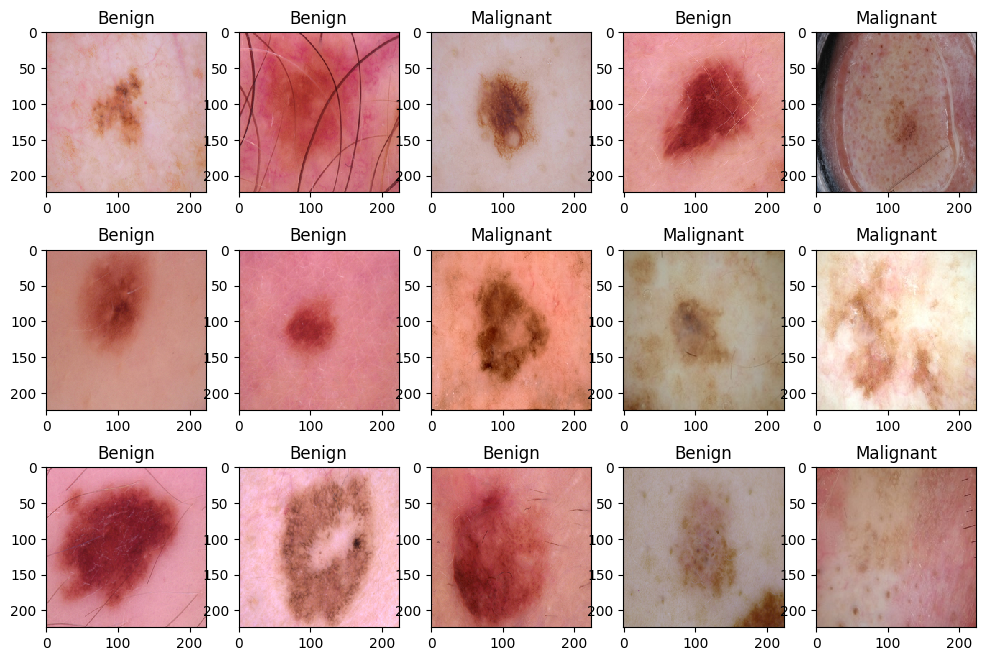

In [5]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()



# Dataset
The dataset is almost balanced. It has 1800 benign samples and 1497 malignant samples

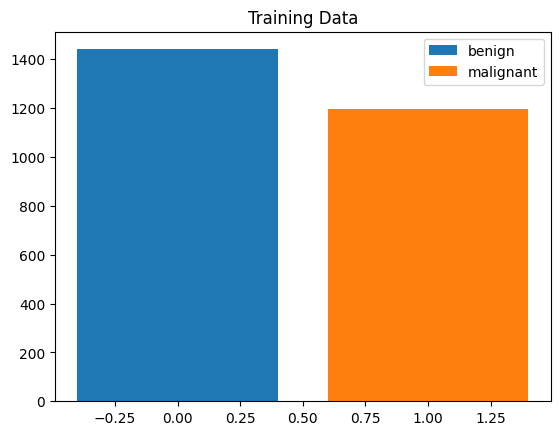

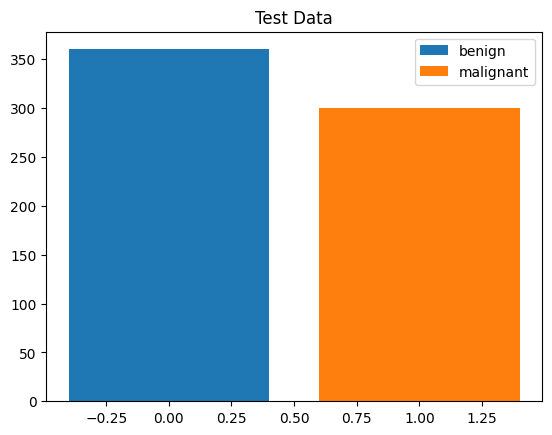

In [6]:
plt.bar(0, y_train[np.where(y_train == 0)].shape[0], label = 'benign')
plt.bar(1, y_train[np.where(y_train == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Training Data")
plt.show()

plt.bar(0, y_test[np.where(y_test == 0)].shape[0], label = 'benign')
plt.bar(1, y_test[np.where(y_test == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Test Data")
plt.show()


# Scale values

scale or normalize the pixel values of images.

Why Normalize?:

* Improved Model Performance: Many machine learning models, especially neural networks, perform better and converge faster during training when input features are normalized. This is because the gradients in the optimization process are more stable.
* Consistency: Normalizing the input data ensures that all input features contribute equally to the model's learning process, avoiding dominance by features with larger numeric ranges.

In [7]:
X_train = X_train/255.
X_test = X_test/255.

# Training a simple Model : SVM

In [8]:
# support vector machine classifier
from sklearn.svm import SVC

modelsvm = SVC(gamma='scale')  # or gamma='auto'

# Reshape the input if necessary and fit the model
modelsvm.fit(X_train.reshape(X_train.shape[0], -1), y_train)


SVC()

# Testing Model

In [9]:
from sklearn.metrics import accuracy_score

y_pred = modelsvm.predict(X_test.reshape(X_test.shape[0],-1))

print(accuracy_score(y_test, y_pred))


0.8348484848484848


# ****EfficientNetB3 Model****

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '../input/data/train',
        target_size=(224,224),
        batch_size=16,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        '../input/data/test',
        target_size=(224,224),
        batch_size=8,
        class_mode='binary')
#model.fit(train_generator,epochs=10,validation_data=validation_generator)


Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [11]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_generator.class_indices.keys())) # to define number of classes in dense layer
# Create Model Structure
base_model =  tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= "sparse_categorical_crossentropy", metrics= ['accuracy'])

model.summary()


43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11,183,665
Trainable params: 11,093,290
Non

**Callback params**

**Train the model**

In [12]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=(train_generator.samples // train_generator.batch_size)-100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=5
)

Epoch 1/5
64/64 [==============================] - 316s 5s/step - loss: 7.7241 - accuracy: 0.7502 - val_loss: 8.3756 - val_accuracy: 0.5442
Epoch 2/5
64/64 [==============================] - 301s 5s/step - loss: 6.2071 - accuracy: 0.8174 - val_loss: 7.9025 - val_accuracy: 0.5457
Epoch 3/5
64/64 [==============================] - 300s 5s/step - loss: 5.2529 - accuracy: 0.8139 - val_loss: 5.8211 - val_accuracy: 0.5488
Epoch 4/5
64/64 [==============================] - 299s 5s/step - loss: 4.4422 - accuracy: 0.8462 - val_loss: 5.1737 - val_accuracy: 0.5457
Epoch 5/5
64/64 [==============================] - 299s 5s/step - loss: 3.8531 - accuracy: 0.8257 - val_loss: 4.1867 - val_accuracy: 0.5473


**Evaluation**

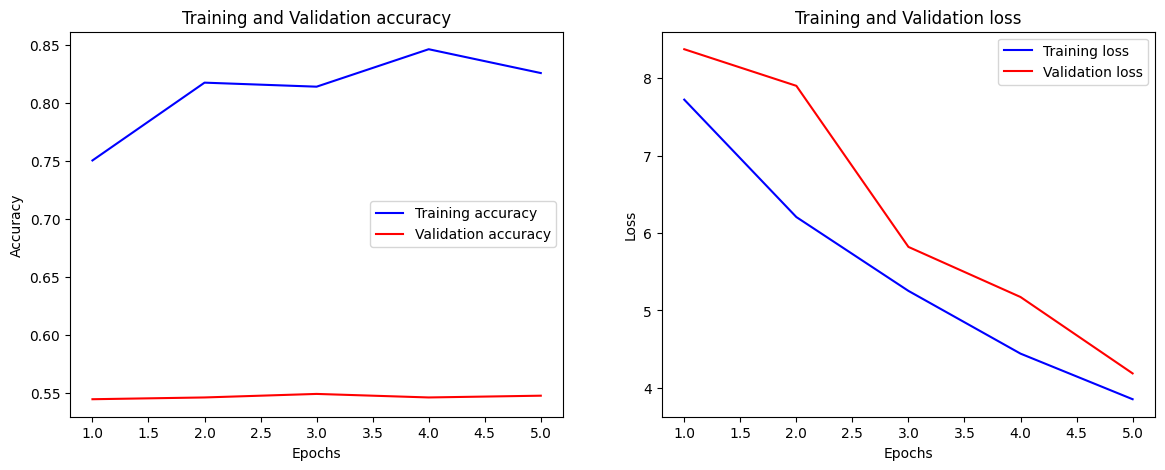

In [13]:
import matplotlib.pyplot as plt

def plot_training(history):
    """
    Plots the training and validation accuracy and loss.
    :param history: History object from model.fit()
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
plot_training(history)



In [14]:
import pickle

model_pkl_file = "skincancer.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)

In [15]:
from keras.models import load_model
model.save('skincancer1.h5')


The model EfficientNetB3 gives us around 93% accuracy which is better than SVM 83% 